In [1]:
from pathlib import Path
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep 
plt.style.use(hep.style.ATLAS)
import awkward as ak
from tqdm import tqdm 
# import ROOT

import joblib
import vector
import numba as nb

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [2]:
Mjj_bin_edges = np.array([ 500.,  850., 1450., 2100., 2550., 3000.], dtype=float)
MT_bin_edges = np.array([0, 100, 180, 230, 280, 350, 500, 800, 1500], dtype=float)

mass_points1 = np.linspace(200, 550, int((550 - 200) / 25 + 1), dtype=int)
mass_points2 = np.linspace(600, 1000, int((1000 - 600) / 100 + 1), dtype=int)
mass_points3 = np.array([1500, 2000, 3000], dtype=int)
mass_points = np.concatenate([mass_points1, mass_points2, mass_points3])

period_labels = np.array(['a', 'd', 'e'])
dsid_map = dict.fromkeys(mass_points)
dsid_start = 511727 
for mass_idx, masss_point in enumerate(mass_points):
    dsid_map[masss_point] = dsid_start + mass_idx

ttree_prefix = 'HWWTree_'
ttree_channels = ['em', 'me', 'ee', 'mm']

In [3]:
df_signal = joblib.load("../signal.pkl")
df_bkg = joblib.load("../bkg.pkl") 

# Prepare Sample

Make equal size of training sample at each mass point.    

In [11]:
df_signal_groupedby = df_signal.groupby('file_identifer')
size_mass_point = df_signal_groupedby.count()['weight'].min()


In [20]:
new_sig_sample = []
for k, group in df_signal_groupedby:
    new_sig_sample.append(group.sample(size_mass_point, random_state=42))

In [23]:
new_sig_sample = pd.concat(new_sig_sample)

In [25]:
new_bkg_sample = df_bkg.sample(new_sig_sample.shape[0], random_state=42)

In [26]:
joblib.dump(new_sig_sample, "./sig.pkl")
joblib.dump(new_bkg_sample, "./bkg.pkl")

['./bkg.pkl']

# Base Model Training

In [4]:
new_sig_sample = joblib.load("./sig.pkl")
new_bkg_sample = joblib.load("./bkg.pkl")

In [5]:
features = new_sig_sample.columns[2:18].tolist() + new_sig_sample.columns[-5:-1].tolist() 

In [6]:
n_samples = new_sig_sample.shape[0]
X = pd.concat([new_sig_sample, new_bkg_sample])
y = np.concatenate([np.ones(n_samples), np.zeros(n_samples)])

In [7]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.1, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.1/0.9 ,random_state=42)

In [8]:
bdt = GradientBoostingClassifier(n_estimators = 100, random_state = 42, verbose=1, validation_fraction=0.1/0.9, n_iter_no_change=10, tol=0.01)
bdt.fit(X_dev[features], y_dev)

      Iter       Train Loss   Remaining Time 
         1           1.3229            2.75m
         2           1.2706            2.64m
         3           1.2274            2.61m
         4           1.1899            2.56m
         5           1.1585            2.53m
         6           1.1305            2.52m
         7           1.1064            2.49m
         8           1.0847            2.46m
         9           1.0662            2.43m
        10           1.0493            2.40m
        20           0.9503            2.13m
        30           0.9076            1.87m
        40           0.8841            1.60m
        50           0.8684            1.33m
        60           0.8582            1.07m


GradientBoostingClassifier(n_iter_no_change=10, random_state=42, tol=0.01,
                           validation_fraction=0.11111111111111112, verbose=1)

## Performance

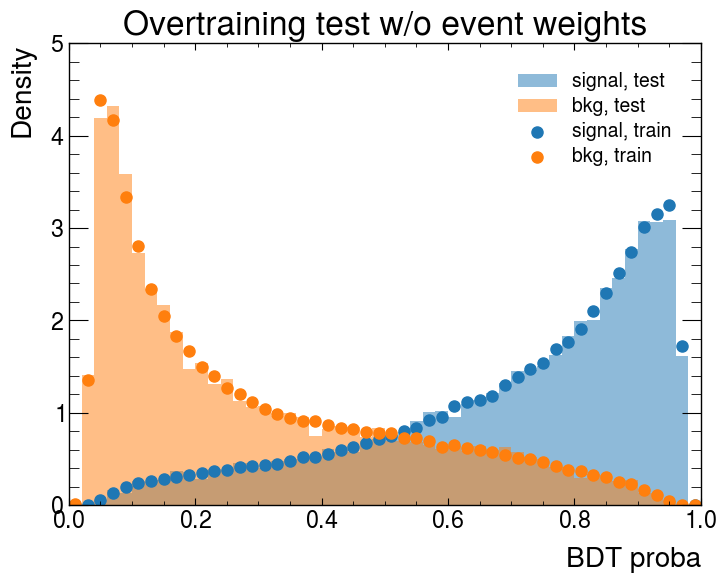

In [9]:
y_test_proba = bdt.predict_proba(X_test[features])[:, 1]
y_train_proba = bdt.predict_proba(X_train[features])[:, 1] 

bin_edges_proba = np.linspace(0, 1, 51)
bin_centers_proba = (bin_edges_proba[1:] + bin_edges_proba[:-1]) / 2

fig, ax = plt.subplots()
ax.hist(y_test_proba[y_test==1], bins=bin_edges_proba, density=True, label="signal, test", alpha=0.5)
ax.hist(y_test_proba[y_test==0], bins=bin_edges_proba, density=True, label="bkg, test", alpha=0.5)

# ax.hist(y_train_proba[y_train==1], bins=bin_edges_proba, density=True, label="train, signal", alpha=0.5)
# ax.hist(y_train_proba[y_train==0], bins=bin_edges_proba, density=True, label="train, bkg", alpha=0.5)


y_train_sig_bin_contents, _ = np.histogram(y_train_proba[y_train==1], bins=bin_edges_proba, density=True)
y_train_bkg_bin_contents, _ = np.histogram(y_train_proba[y_train==0], bins=bin_edges_proba, density=True)

ax.scatter(bin_centers_proba, y_train_sig_bin_contents, label="signal, train")
ax.scatter(bin_centers_proba, y_train_bkg_bin_contents, label="bkg, train")

ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Density")
ax.set_title("Overtraining test w/o event weights")
plt.show()

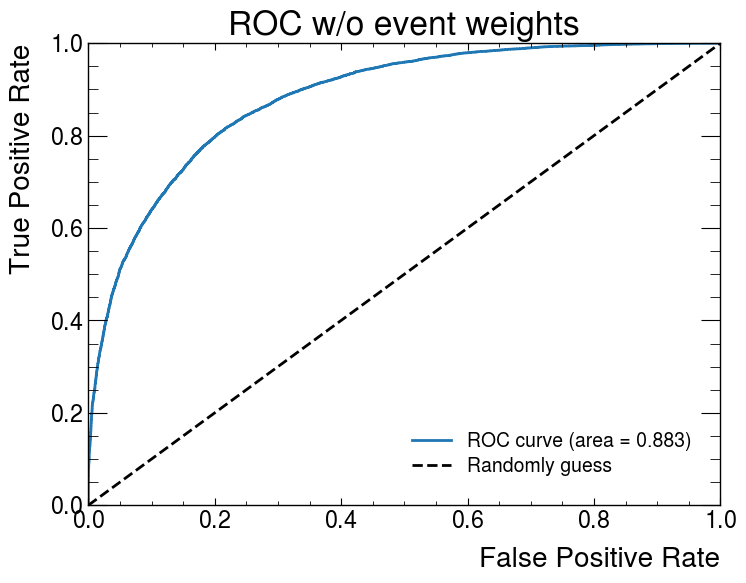

In [36]:
# fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

ax.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})" )
ax.plot([0, 1], [0, 1], 'k--', label='Randomly guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")
ax.set_title("ROC w/o event weights") 

plt.show()


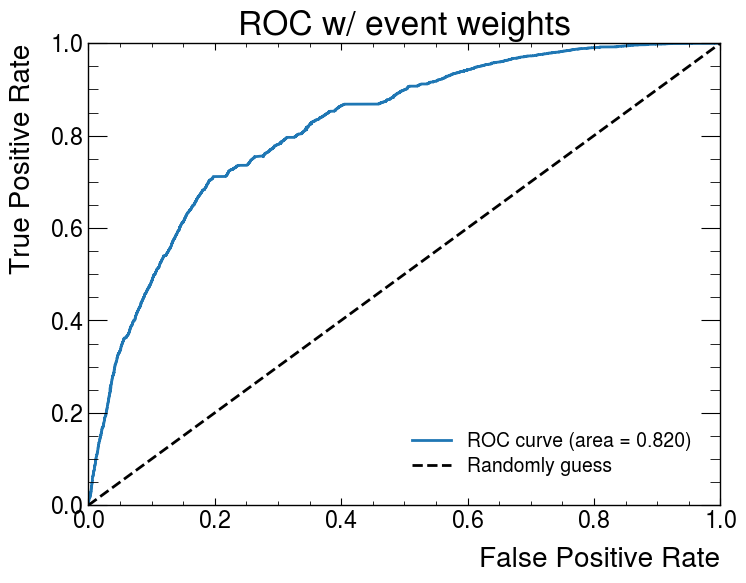

In [43]:
# fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])

# sort the thresholds, fpr, tpr by fpr
fpr, tpr, thresholds = zip(*sorted(zip(fpr, tpr, thresholds)))


ax.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})" )
ax.plot([0, 1], [0, 1], 'k--', label='Randomly guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")
ax.set_title("ROC w/ event weights") 

plt.show()

In [44]:
df_signal['bdt_proba'] = bdt.predict_proba(df_signal[features])[:, 1]
df_bkg['bdt_proba'] = bdt.predict_proba(df_bkg[features])[:, 1]

In [46]:
def calculate_significance(S, B):
    return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))

/tmp/ipykernel_88435/31159572.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))


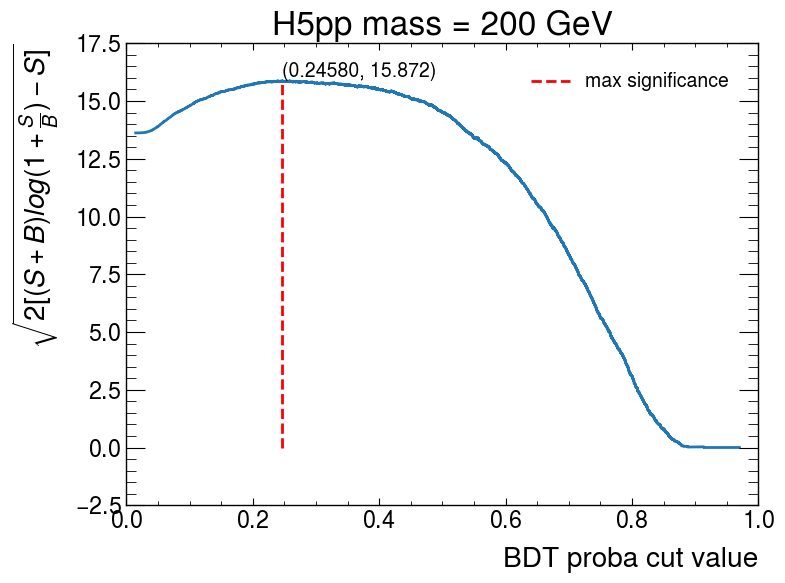

In [50]:
df_signal_groubpy = df_signal.groupby('file_identifer')
df_signal_m200 = df_signal_groubpy.get_group('signal_m200')
combined = pd.concat([df_signal_m200, df_bkg])
fpr, tpr, thresholds = roc_curve(combined['target'], combined['bdt_proba'], sample_weight=combined['weight']) 

n_sig = df_signal_m200['weight'].sum() 
n_bkg = df_bkg['weight'].sum()

S = n_sig*tpr
B = n_bkg*fpr
metric = calculate_significance(S, B)

arg_idx= np.argmax(metric[1:])


plt.plot(thresholds, metric)
plt.xlabel('BDT proba cut value')
plt.ylabel('$\\sqrt{2 [(S +B ) log(1+\\frac{S}{B}) - S] }$')
plt.title("H5pp mass = 200 GeV")
plt.xlim(0, 1.0)
plt.vlines(thresholds[arg_idx], 0, metric[arg_idx+1], color='r', linestyle='--', label=f"max significance")
plt.text(thresholds[arg_idx], metric[arg_idx+1], f"({thresholds[arg_idx]:.5f}, {metric[arg_idx+1]:.3f})", ha='left', va='bottom')
plt.legend()

bdt_proba_cut = thresholds[arg_idx]


# Tuning

In [51]:
import optuna
from optuna.samplers import TPESampler

In [54]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-1, 1), 
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_samples_split": trial.suggest_float("min_samples_split", 0.1, 1.0),
        "min_samples_leaf": trial.suggest_float("min_samples_leaf", 0.1, 0.5),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
    }
    
    # use 1/9 of the dev set as the validation set and set the early stopping criteria
    gbdt = GradientBoostingClassifier(**param, random_state=42, validation_fraction=0.1, n_iter_no_change=10, tol=0.001)
    gbdt.fit(X_train[features], y_train)

    # choose the highest auc score with event weight  
    y_val_decisions = gbdt.predict_proba(X_val[features])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_decisions, sample_weight=X_val['weight'])
    # sort the fpr and tpr and thresholds in ascending order of fpr
    fpr, tpr, thresholds = zip(*sorted(zip(fpr, tpr, thresholds)))
    roc_auc = auc(fpr, tpr)

    return roc_auc

sampler = TPESampler(seed=42)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler, study_name="sklearn GBDT training")
study.optimize(objective, n_trials=100, n_jobs=10)

[I 2023-05-18 23:36:13,709] A new study created in memory with name: sklearn GBDT training
[I 2023-05-18 23:36:24,041] Trial 8 finished with value: 0.8257588028065209 and parameters: {'learning_rate': 0.7825397670268769, 'max_depth': 5, 'n_estimators': 216, 'min_samples_split': 0.827418310563202, 'min_samples_leaf': 0.16578140818250725, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.8257588028065209.
[I 2023-05-18 23:36:28,864] Trial 0 finished with value: 0.7855553933193358 and parameters: {'learning_rate': 0.15263120400328595, 'max_depth': 2, 'n_estimators': 299, 'min_samples_split': 0.1622092235322402, 'min_samples_leaf': 0.4606327204333992, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.8257588028065209.
[I 2023-05-18 23:36:29,716] Trial 9 finished with value: 0.824054001011234 and parameters: {'learning_rate': 0.24965884719000608, 'max_depth': 5, 'n_estimators': 441, 'min_samples_split': 0.9851846242876054, 'min_samples_leaf': 0.1269524255710223, 'max_features': 's

# The Best Model

In [65]:
best_params = study.best_params
print(best_params)

{'learning_rate': 0.534322286186369, 'max_depth': 8, 'n_estimators': 390, 'min_samples_split': 0.2819168018160169, 'min_samples_leaf': 0.11167824422964545, 'max_features': None}


In [58]:
best_gbdt_model = GradientBoostingClassifier(**study.best_params, random_state=42, validation_fraction=0.1, n_iter_no_change=10, tol=0.001)

In [63]:
best_gbdt_model.fit(X_train[features], y_train)

GradientBoostingClassifier(learning_rate=0.534322286186369, max_depth=8,
                           min_samples_leaf=0.11167824422964545,
                           min_samples_split=0.2819168018160169,
                           n_estimators=390, n_iter_no_change=10,
                           random_state=42, tol=0.001)

In [88]:
pd.DataFrame(best_gbdt_model.feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)

,importance
dyjj,0.555840
jet1_pt,0.112492
jet0_pt,0.094951
lep1_pt,0.093884
lep0_pt,0.056566
met,0.043468
lep0_eta,0.010802
nJets,0.009794
lep1_eta,0.008064
lep0_pz,0.003080


In [64]:
joblib.dump(best_gbdt_model, 'best_gbdt_model.pkl')

['best_gbdt_model.pkl']

## Performance 

### w/o event weight

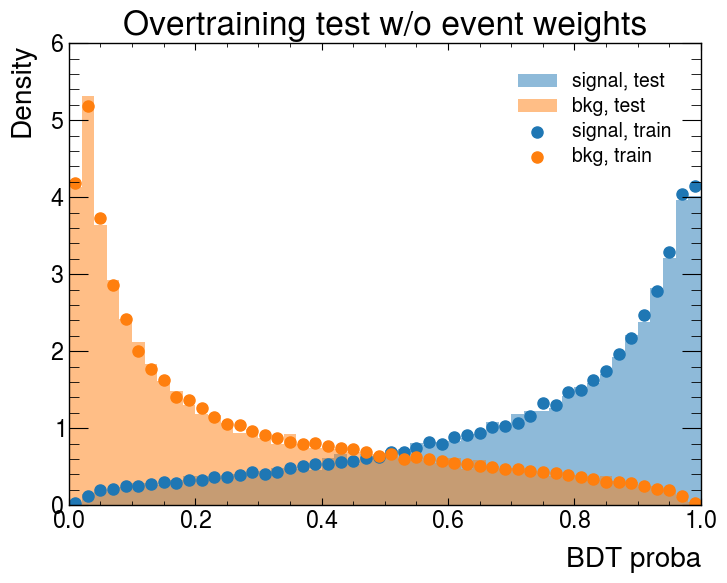

In [66]:
y_test_proba = best_gbdt_model.predict_proba(X_test[features])[:, 1]
y_train_proba = best_gbdt_model.predict_proba(X_train[features])[:, 1] 

bin_edges_proba = np.linspace(0, 1, 51)
bin_centers_proba = (bin_edges_proba[1:] + bin_edges_proba[:-1]) / 2

fig, ax = plt.subplots()
ax.hist(y_test_proba[y_test==1], bins=bin_edges_proba, density=True, label="signal, test", alpha=0.5)
ax.hist(y_test_proba[y_test==0], bins=bin_edges_proba, density=True, label="bkg, test", alpha=0.5)

# ax.hist(y_train_proba[y_train==1], bins=bin_edges_proba, density=True, label="train, signal", alpha=0.5)
# ax.hist(y_train_proba[y_train==0], bins=bin_edges_proba, density=True, label="train, bkg", alpha=0.5)


y_train_sig_bin_contents, _ = np.histogram(y_train_proba[y_train==1], bins=bin_edges_proba, density=True)
y_train_bkg_bin_contents, _ = np.histogram(y_train_proba[y_train==0], bins=bin_edges_proba, density=True)

ax.scatter(bin_centers_proba, y_train_sig_bin_contents, label="signal, train")
ax.scatter(bin_centers_proba, y_train_bkg_bin_contents, label="bkg, train")

ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Density")
ax.set_title("Overtraining test w/o event weights")
plt.show()

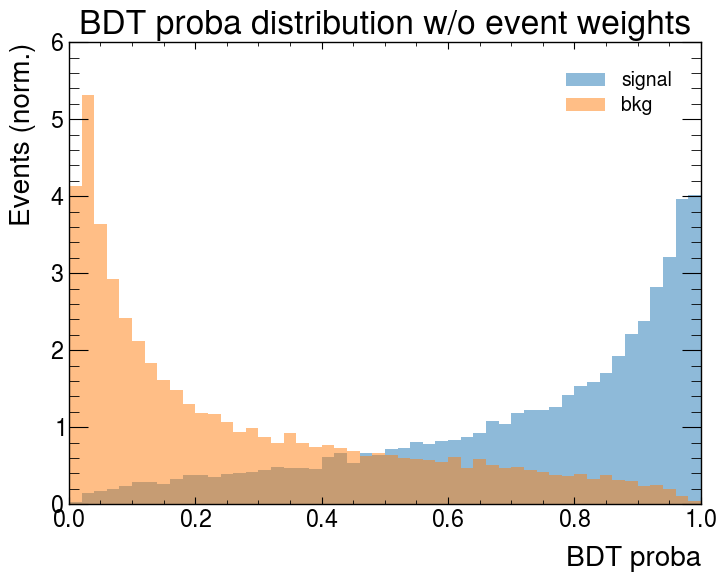

In [89]:
fig, ax = plt.subplots()

ax.hist(y_test_proba[y_test == 1], bins=bin_edges_proba, density=True, alpha=0.5, label="signal")
ax.hist(y_test_proba[y_test == 0], bins=bin_edges_proba, density=True, alpha=0.5, label="bkg")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (norm.)")
ax.set_title("BDT proba distribution w/o event weights") 
plt.show()

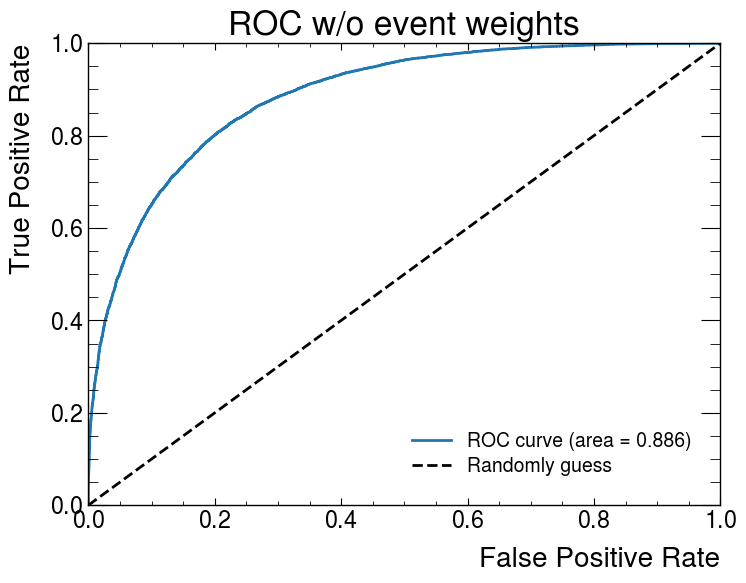

In [67]:
# fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

ax.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})" )
ax.plot([0, 1], [0, 1], 'k--', label='Randomly guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")
ax.set_title("ROC w/o event weights") 

plt.show()


### w event weight

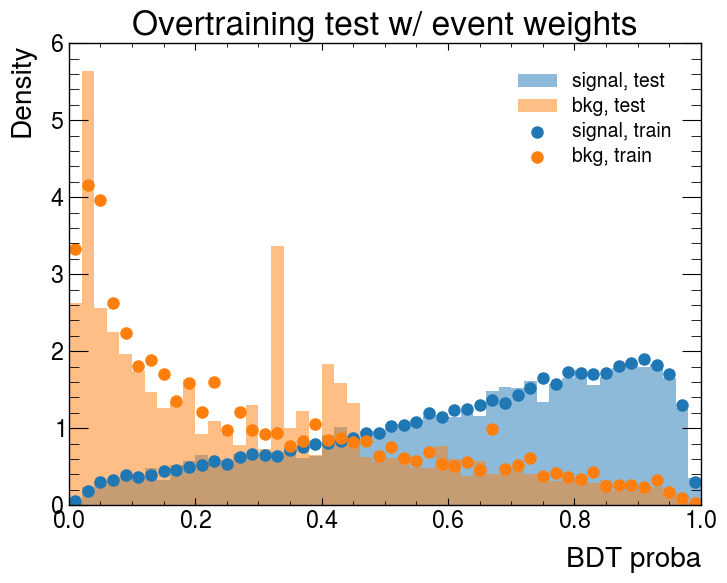

In [73]:
y_test_proba = best_gbdt_model.predict_proba(X_test[features])[:, 1]
y_train_proba = best_gbdt_model.predict_proba(X_train[features])[:, 1] 

bin_edges_proba = np.linspace(0, 1, 51)
bin_centers_proba = (bin_edges_proba[1:] + bin_edges_proba[:-1]) / 2

fig, ax = plt.subplots()
ax.hist(y_test_proba[y_test==1], bins=bin_edges_proba, 
        weights=X_test.loc[y_test==1, 'weight'], density=True, label="signal, test", alpha=0.5)
ax.hist(y_test_proba[y_test==0], bins=bin_edges_proba,
        weights=X_test.loc[y_test==0, 'weight'], density=True, label="bkg, test", alpha=0.5)

# ax.hist(y_train_proba[y_train==1], bins=bin_edges_proba, density=True, label="train, signal", alpha=0.5)
# ax.hist(y_train_proba[y_train==0], bins=bin_edges_proba, density=True, label="train, bkg", alpha=0.5)


y_train_sig_bin_contents, _ = np.histogram(y_train_proba[y_train==1], bins=bin_edges_proba, 
                                           weights=X_train.loc[y_train==1, 'weight'], density=True)
y_train_bkg_bin_contents, _ = np.histogram(y_train_proba[y_train==0], bins=bin_edges_proba, 
                                           weights=X_train.loc[y_train==0, 'weight'], density=True)

ax.scatter(bin_centers_proba, y_train_sig_bin_contents, label="signal, train")
ax.scatter(bin_centers_proba, y_train_bkg_bin_contents, label="bkg, train")

ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Density")
ax.set_title("Overtraining test w/ event weights")
plt.show()

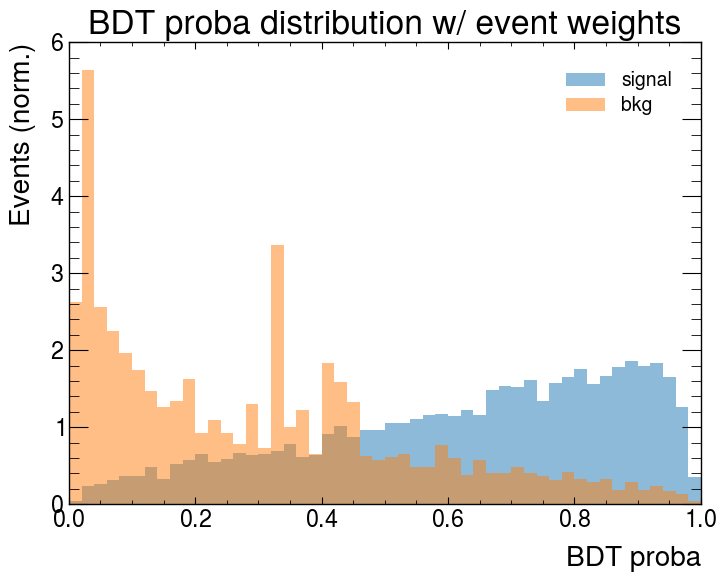

In [90]:
fig, ax = plt.subplots()

ax.hist(y_test_proba[y_test == 1], bins=bin_edges_proba, density=True, weights = X_test.loc[y_test == 1, 'weight'], alpha=0.5, label="signal")
ax.hist(y_test_proba[y_test == 0], bins=bin_edges_proba, density=True, weights = X_test.loc[y_test == 0, 'weight'], alpha=0.5, label="bkg")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (norm.)")
ax.set_title("BDT proba distribution w/ event weights") 
plt.show()

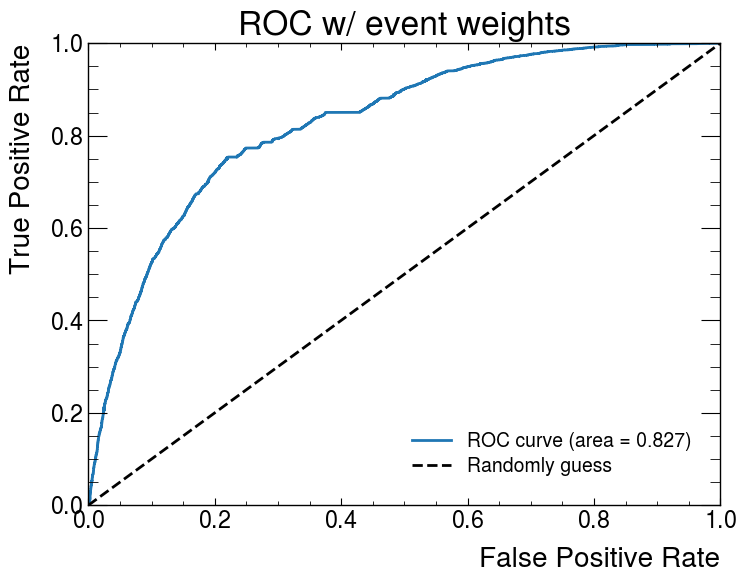

In [74]:
# fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])

# sort the thresholds, fpr, tpr by fpr
fpr, tpr, thresholds = zip(*sorted(zip(fpr, tpr, thresholds)))


ax.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})" )
ax.plot([0, 1], [0, 1], 'k--', label='Randomly guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")
ax.set_title("ROC w/ event weights") 

plt.show()

### significance

In [77]:
df_signal['bdt_proba'] = best_gbdt_model.predict_proba(df_signal[features])[:, 1]
df_bkg['bdt_proba'] = best_gbdt_model.predict_proba(df_bkg[features])[:, 1]

/tmp/ipykernel_88435/31159572.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))


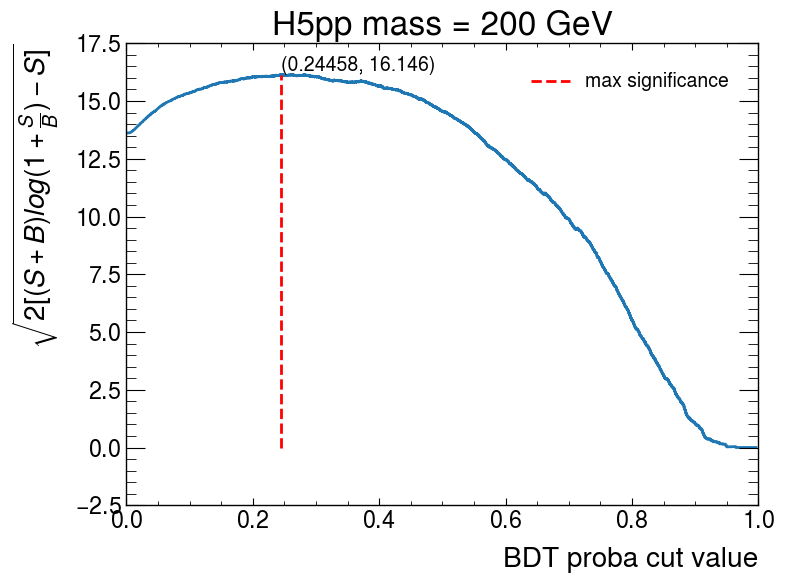

In [78]:
df_signal_groubpy = df_signal.groupby('file_identifer')
df_signal_m200 = df_signal_groubpy.get_group('signal_m200')
combined = pd.concat([df_signal_m200, df_bkg])
fpr, tpr, thresholds = roc_curve(combined['target'], combined['bdt_proba'], sample_weight=combined['weight']) 

n_sig = df_signal_m200['weight'].sum() 
n_bkg = df_bkg['weight'].sum()

S = n_sig*tpr
B = n_bkg*fpr
metric = calculate_significance(S, B)

arg_idx= np.argmax(metric[1:])


plt.plot(thresholds, metric)
plt.xlabel('BDT proba cut value')
plt.ylabel('$\\sqrt{2 [(S +B ) log(1+\\frac{S}{B}) - S] }$')
plt.title("H5pp mass = 200 GeV")
plt.xlim(0, 1.0)
plt.vlines(thresholds[arg_idx], 0, metric[arg_idx+1], color='r', linestyle='--', label=f"max significance")
plt.text(thresholds[arg_idx], metric[arg_idx+1], f"({thresholds[arg_idx]:.5f}, {metric[arg_idx+1]:.3f})", ha='left', va='bottom')
plt.legend()

bdt_proba_cut = thresholds[arg_idx]


Text(0.5, 1.0, 'BDT proba distribution w/ event weights')

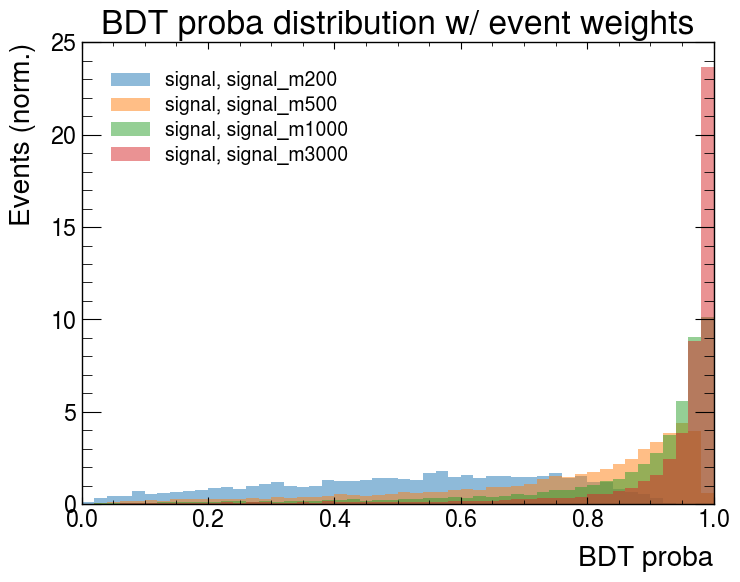

In [79]:
fig, ax = plt.subplots() 
bin_edges_proba = np.linspace(0, 1, 51)
for mass_point in ['signal_m200', 'signal_m500', 'signal_m1000', 'signal_m3000']:
    bdt_proba = df_signal_groubpy.get_group(mass_point)['bdt_proba']
    weights = df_signal_groubpy.get_group(mass_point)['weight']
    ax.hist(bdt_proba, bins=bin_edges_proba, density=True, weights=weights, alpha=0.5, label=f"signal, {mass_point}")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (norm.)")
ax.set_title("BDT proba distribution w/ event weights")

Text(0.5, 1.0, 'BDT proba distribution w/ event weights')

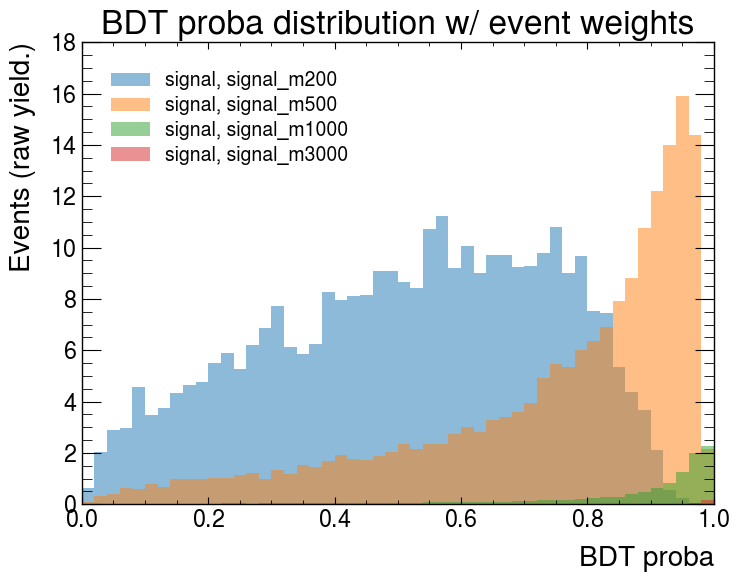

In [80]:
fig, ax = plt.subplots() 
bin_edges_proba = np.linspace(0, 1, 51)
for mass_point in ['signal_m200', 'signal_m500', 'signal_m1000', 'signal_m3000']:
    bdt_proba = df_signal_groubpy.get_group(mass_point)['bdt_proba']
    weights = df_signal_groubpy.get_group(mass_point)['weight']
    ax.hist(bdt_proba, bins=bin_edges_proba, weights=weights, alpha=0.5, label=f"signal, {mass_point}")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (raw yield.)")
ax.set_title("BDT proba distribution w/ event weights")

# Significance Benchmark

In [81]:
import re

B = df_bkg['weight'].sum()
significance_benchmark = {}
for key, value in df_signal_groubpy:
    matched = re.findall(r"signal_m(\d+)", key)
    if matched: 
        mass_point = int(matched[0])

    S = value['weight'].sum()
    significance_benchmark[mass_point] = calculate_significance(S, B)


In [85]:
B = df_bkg.loc[df_bkg['bdt_proba'] > bdt_proba_cut, 'weight'].sum()

significance_improved = {}
for key, value in df_signal_groubpy:
    matched = re.findall(r"signal_m(\d+)", key)
    if matched: 
        mass_point = int(matched[0])

    S = value.loc[value['bdt_proba'] > bdt_proba_cut, 'weight'].sum()
    significance_improved[mass_point] = calculate_significance(S, B)

Text(0.5, 1.0, 'Significance vs H5pp mass point')

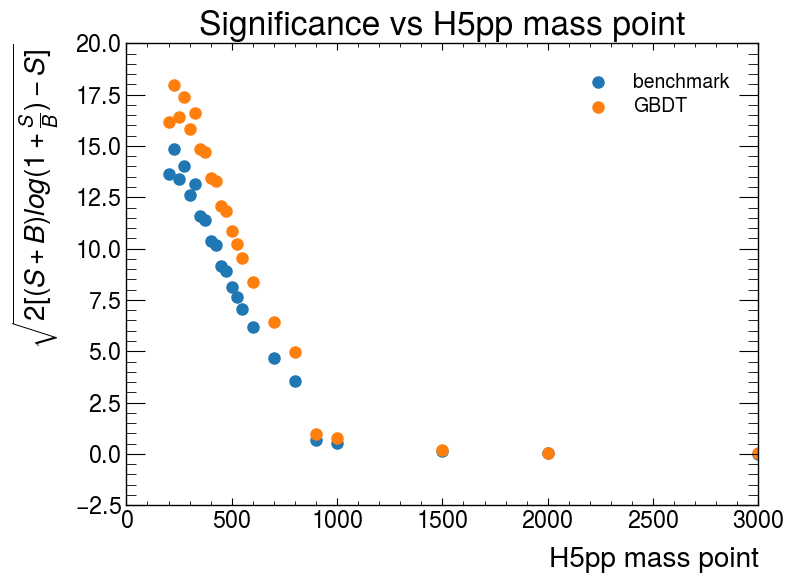

In [87]:

fig, ax = plt.subplots()
plt.scatter(significance_benchmark.keys(), significance_benchmark.values(), label="benchmark")
plt.scatter(significance_improved.keys(), significance_improved.values(), label="GBDT")
plt.ylabel('$\\sqrt{2 [(S +B ) log(1+\\frac{S}{B}) - S] }$')
plt.xlabel('H5pp mass point')
plt.legend()
plt.title("Significance vs H5pp mass point")